# Analyzing Airbnb Data

We'll start by importing relevant _libraries_ (i.e. prebuilt chunks of Python that have useful functions).

In [181]:
import pandas as pd    #data manipulation
import numpy as np     #mathematical operations

import matplotlib.pyplot as plt      #plotting tools
import geopandas as gpd              #geo mapping tools
import contextily as ctx             #map illustrating tool

from urllib.request import urlopen   #web url reading
import json                          #json reader

We will downlaod data directly from from [Inside Airbnb](http://insideairbnb.com/get-the-data.html]) as a pandas _dataframe_.

In [209]:
df = pd.read_csv("http://data.insideairbnb.com/united-states/ca/san-francisco/2021-04-07/visualisations/listings.csv")
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,958,"Bright, Modern Garden Unit - 1BR/1BTH",1169,Holly,NaN,Western Addition,37.770280,-122.433170,Entire home/apt,150,2,277,2021-04-05,1.94,1,112
1,5858,Creative Sanctuary,8904,NaN,NaN,Bernal Heights,37.744740,-122.420890,Entire home/apt,195,30,111,2017-08-06,0.76,1,365
2,7918,A Friendly Room - UCSF/USF - San Francisco,21994,Aaron,NaN,Haight Ashbury,37.765550,-122.452130,Private room,56,32,19,2020-03-06,0.13,8,365
3,8142,Friendly Room Apt. Style -UCSF/USF - San Franc...,21994,Aaron,NaN,Haight Ashbury,37.765550,-122.452130,Private room,56,32,8,2018-09-12,0.10,8,365
4,8339,Historic Alamo Square Victorian,24215,Rosy,NaN,Western Addition,37.775640,-122.436420,Entire home/apt,795,7,28,2019-06-28,0.20,2,364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6677,49061200,"Brand New, Modern 1 Bedroom in Pacific Heights",129904961,Galina,NaN,Pacific Heights,37.794186,-122.426405,Entire home/apt,135,30,0,NaN,NaN,3,259
6678,49062947,Junior Studio Room with Front Deck,203065170,Serhan,NaN,Noe Valley,37.749210,-122.430930,Private room,55,30,0,NaN,NaN,16,31
6679,49064041,Sunny Modern Top Floor Nob/Russian Hill 2BR,7239867,Brian,NaN,Nob Hill,37.791330,-122.419870,Entire home/apt,188,55,0,NaN,NaN,3,90
6680,49079039,Sunny Russian Hill Apt with Private Backyard &...,12850096,Benjamin,NaN,Russian Hill,37.799576,-122.422638,Entire home/apt,126,60,0,NaN,NaN,1,318


# Exploratory Data Analysis

We will use a for loop to see which columns are in this _dataframe_.

In [210]:
for c in df.columns:
    print(c)

id
name
host_id
host_name
neighbourhood_group
neighbourhood
latitude
longitude
room_type
price
minimum_nights
number_of_reviews
last_review
reviews_per_month
calculated_host_listings_count
availability_365


We can count the entries in a given column using `df["<columns_name>"].value_counts()`.

In [211]:
host_listing_dict = df["host_id"].value_counts()

In [337]:
pro_hosts = []

for k,v in host_listing_dict.items():
    if v > 1:
        pro_hosts.append(k)

In [338]:
df["pro_host"] = np.nan

for i in df.index:
    top = df.loc[i,"host_id"] in pro_hosts
    df.loc[i,"pro_host"] = top

# Preliminary Plotting

Choose plot colors from [Color Universal Design](https://jfly.uni-koeln.de/color/), by M. Okabe and K. Ito.

![universal_colors.png](https://github.com/annahaensch/DataAndSocialJustice/blob/main/Figures/universal_colors.png?raw=true)

In [339]:
colors = ['#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000']

In [340]:
room_type_dict = df['room_type'].value_counts().to_dict()

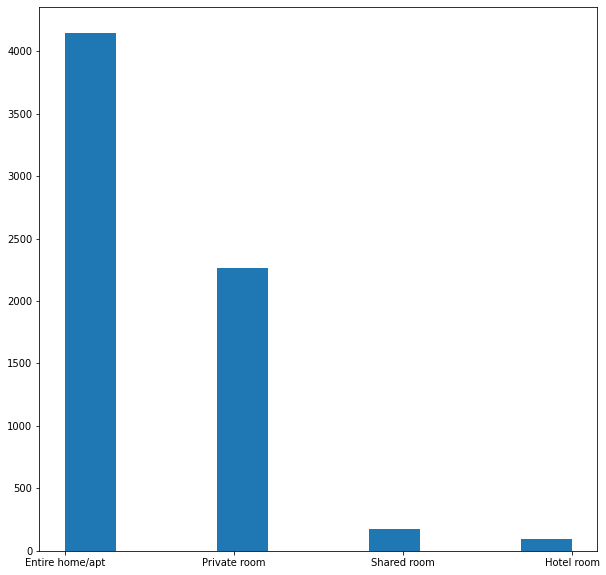

In [341]:
fig, ax = plt.subplots(figsize = (10,10))

ax.hist(df['room_type'])

plt.show()

# Preliminary Mapping

We will start by getting the geometry of the neighborhood coordinates from Inside Airbnb.

In [342]:
url = "http://data.insideairbnb.com/united-states/ca/san-francisco/2021-04-07/visualisations/neighbourhoods.geojson"

#read geojson file from url
nbhd_df = gpd.read_file(url) 

#Project onto a flat crs for mapping.
nbhd_df = nbhd_df.to_crs(epsg=3857) 

nbhd_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Seacliff,None,"MULTIPOLYGON (((-13634866.418 4549507.782, -13..."
1,Haight Ashbury,None,"MULTIPOLYGON (((-13629509.167 4546849.811, -13..."
2,Outer Mission,None,"MULTIPOLYGON (((-13631548.540 4538288.971, -13..."
3,Downtown/Civic Center,None,"MULTIPOLYGON (((-13626497.752 4549820.778, -13..."
4,Diamond Heights,None,"MULTIPOLYGON (((-13629460.521 4542966.888, -13..."


Next we will get the geometry for the individual listings.

In [353]:
geo_df = geopandas.GeoDataFrame(df[["latitude","longitude","pro_host","geometry"]], 
                                geometry=geopandas.points_from_xy(df.longitude, df.latitude))

#Add spherical coordinate reference system (crs) to lat/long pairs.
geo_df.crs = "EPSG:4326" 

#Project onto a flat crs for mapping.
geo_df = geo_df.to_crs(epsg=3857) 

geo_df.head()

,latitude,longitude,pro_host,geometry
0,37.77028,-122.43317,False,POINT (-13629198.141 4547024.716)
1,37.74474,-122.42089,False,POINT (-13627831.137 4543428.629)
4,37.77564,-122.43642,True,POINT (-13629559.929 4547779.573)
6,37.75831,-122.41386,False,POINT (-13627048.561 4545339.159)
7,37.79249,-122.41499,False,POINT (-13627174.352 4550152.941)


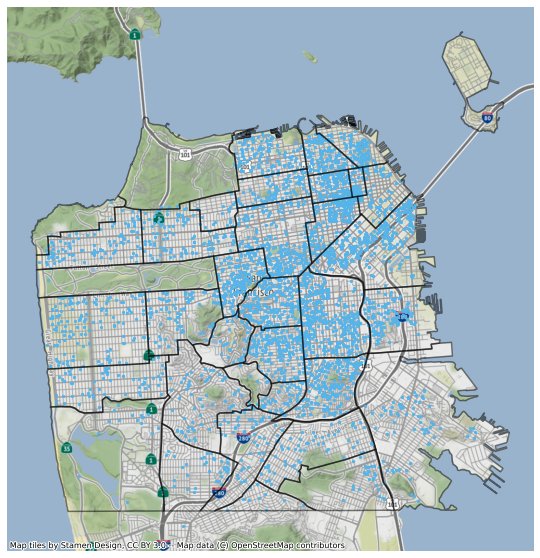

In [351]:
fig, ax = plt.subplots(figsize = (10,10))

# Plot neighborhood boundaries
nbhd_df.geometry.boundary.plot(ax = ax, alpha=0.5, edgecolor='k', color = 'k')

# Plot listings as points.
geo_df.plot(ax = ax, marker = "o", markersize = 5, color = colors[1])

# Add basemap behind geopandas plot.
ctx.add_basemap(ax)

# Turn off axes
ax.set_axis_off()

plt.show()

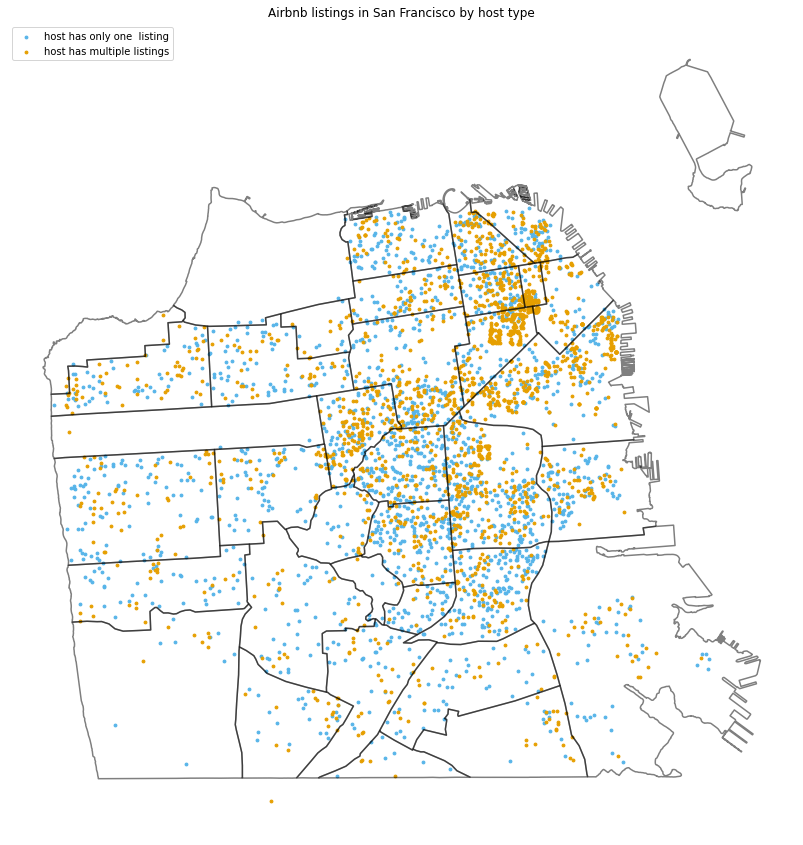

In [352]:
fig, ax = plt.subplots(figsize = (15,15))

# Plot neighborhood boundaries
nbhd_df.geometry.boundary.plot(ax = ax, alpha=0.5, edgecolor='k', color = 'k')

# Plot listings as points.
geo_df[geo_df["pro_host"] == False].plot(ax = ax, marker = "o", markersize = 8, color = colors[1], label = "host has only one  listing")
geo_df[geo_df["pro_host"] == True].plot(ax = ax, marker = "o", markersize = 8, color = colors[0], label = "host has multiple listings")

# Add basemap behind geopandas plot.
#ctx.add_basemap(ax)

# Turn off axes
ax.set_axis_off()

plt.title("Airbnb listings in San Francisco by host type")
plt.legend(loc = "upper left")
plt.show()